<a href="https://colab.research.google.com/github/govardhan-06/DL-models/blob/main/FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.makedirs("data",exist_ok=True)
os.makedirs("data/fer2013",exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Source folder path in Google Drive
src_folder = '/content/drive/MyDrive/AIML'

# Destination folder path in Colab
dest_folder = '/content/data/fer2013'

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Copy the entire folder
shutil.copytree(src_folder, dest_folder, dirs_exist_ok=True)

'/content/data/fer2013'

###1. Data Ingestion phase

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision.datasets

train_set= torchvision.datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor(),
    target_transform=None,
)

test_set= torchvision.datasets.FER2013(
    root="data",
    split="test",
    transform=ToTensor(),
    target_transform=None,
)

In [ ]:
print(f"Length of train set: {len(train_set)}")
print(f"Length of test set: {len(test_set)}")

In [ ]:
print(train_set)
print("\n")
print(test_set)

In [ ]:
import pandas as pd
df=pd.read_csv("data/fer2013/train.csv")
##Does not having a labels for different emotions inside the dataset

In [ ]:
print("Sample data:")
print(train_set.__getitem__(10))

In [ ]:
##Mapping emotion label to the respective emotion terms
emotion_label_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
df['Emotions']= df['emotion'].map(emotion_label_map)
df.head()

### Checking the input and output

In [ ]:
image, label = train_set.__getitem__(0)
print(f"Image shape: {image.shape} -> [colour_channels,height,width]")
print(f"Image label: {label}")

### Visualizing the image

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(emotion_label_map[label])
plt.axis("off")
plt.show()

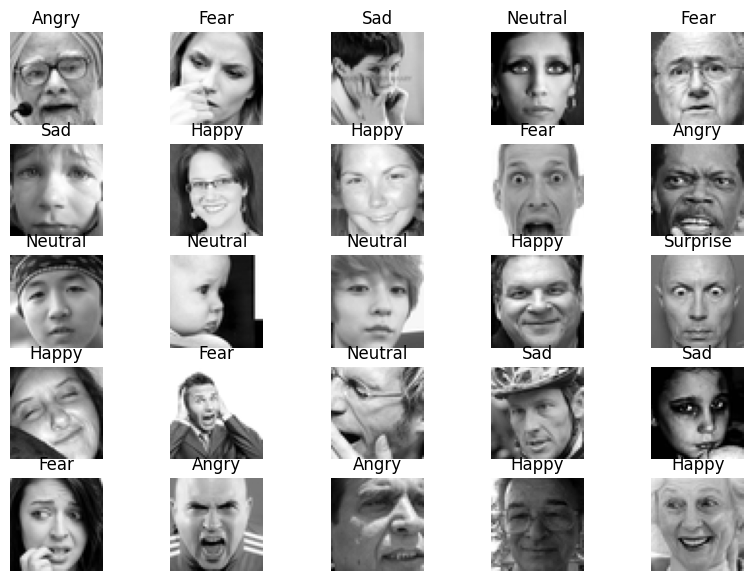

In [ ]:
torch.manual_seed(42)
rows,cols=5,5
plt.figure(figsize=(10,7))
for i in range(1,rows*cols+1):
  img,label=train_set[i]
  plt.subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(emotion_label_map[label])
  plt.axis('off')

### Turning image data to batches

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader= DataLoader(train_set,BATCH_SIZE,shuffle=True)
test_dataloader= DataLoader(test_set,BATCH_SIZE,shuffle=True)

In [ ]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of batch size : {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of batch size : {BATCH_SIZE}")

### Inspection image inside the batch

In [ ]:
train_batch_image, train_batch_label=next(iter(train_dataloader))
print(f"Image batch shape: {train_batch_image.shape} -> [batch_size,colour_channels,height,width]")
print(f"Label batch shape: {train_batch_label.shape} -> [batch_size]")

In [ ]:
plt.figure(figsize=(20,10))
print("First Batch")
for i in range(0,BATCH_SIZE):
  plt.subplot(4,8,i+1)
  plt.imshow(train_batch_image[i].squeeze(),cmap="gray")
  plt.title(emotion_label_map[train_batch_label[i].item()])
  plt.axis('off')

### Device agnostic code

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

### Model Training

In [ ]:
import torchvision.models as models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model,input_size=(32, 3, 224, 224),col_names=["input_size", "output_size", "num_params", "trainable"])

### Transfer Learning

In [ ]:
#Freezing the Base layers
for param in model.parameters():
  param.requires_grad=False

In [ ]:
# Modify the first convolutional layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                        stride=model.conv1.stride, padding=model.conv1.padding, bias=False)

In [ ]:
#Altering the classifier to make it apt for our purpose
torch.manual_seed(42) #CPU
torch.cuda.manual_seed(42) #GPU
model.fc=nn.Linear(in_features=512,out_features=7,bias=True)

In [ ]:
summary(model,input_size=(32, 1, 224, 224),col_names=["input_size", "output_size", "num_params", "trainable"])

### Training

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
model.to(device)

In [ ]:
import tqdm as tqdm
from typing import Tuple

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float,float]:
      '''
      Performs a training with model trying to learn on dataloader.
      Returns train loss and train accuracy.
      '''
      model.train()
      train_loss,train_acc=0,0
      for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      train_loss/=len(dataloader)
      train_acc/=len(dataloader)
      return train_loss,train_acc

def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device) -> Tuple[float,float]:
      '''
      Performs a testing with model on dataloader.
      Returns test loss and test accuracy.
      '''
      model.eval()
      test_loss,test_acc=0,0
      with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
          X,y=X.to(device),y.to(device)
          y_pred=model(X)
          loss=loss_fn(y_pred,y)
          test_loss+=loss.item()
          y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
          test_acc+=(y_pred_class==y).sum().item()/len(y_pred)
      test_loss/=len(dataloader)
      test_acc/=len(dataloader)
      return test_loss,test_acc

In [ ]:
def train_test(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               epochs:int=5):
  '''
  Trains and tests a given PyTorch model.
  '''

  results={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm.tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc}")
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    if epoch%10==0:
      print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} | Test acc: {test_acc}")

In [ ]:
train_test(model=model,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          device=device,
          epochs=100)